In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import torch

from policy import DPAgent
from new_new_policy import DiscretizedDPAgent
from simulation import Simulator, CustomerGenerator
from hazard_models import ExponentialHazard
from utility_learner import ProjectedVolumeLearner, diam
from degradation_learner import DegradationLearner

from utils import unit_ball_rejection_sample, correct_signs
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import logging
logging.basicConfig(level=logging.INFO)

np.set_printoptions(suppress=True)

In [2]:
# --- 2. Define Sampling Functions ---
# def context_sampler() -> np.ndarray:
#     """Samples a customer's context vector from a uniform distribution."""
#     return np.random.uniform(low=0.0, high=1.0, size=D)

def context_sampler() -> np.ndarray:
    """Samples a customer's context vector uniformly from the unit ball."""
    return np.abs(unit_ball_rejection_sample(D))

def rental_sampler() -> float:
    """Samples a customer's desired rental duration from an exponential distribution."""
    return np.random.exponential(scale=10.0)

def interarrival_sampler() -> float:
    """Samples the time until the next customer arrives."""
    return np.random.exponential(scale=5.0)

In [3]:
# --- 1. Simulation Configuration ---
D = 4                                  # Dimension of context vectors
LAMBDA_VAL = 0.001                     # Baseline hazard constant
NUM_CUSTOMERS = 20000                   # Total number of customers to simulate, i.e. T

# Set a random seed for reproducibility
np.random.seed(41)

# Ground truth vectors
THETA_TRUE = np.array([0.5, 0.2, 0.4, 0.3])#$, 0.4])    # For degradation
UTILITY_TRUE = np.array([0.372450167, 0.10850869, 0.33930126, 0.71356037])

# context_sampler()  # For customer's willingness to pay

# --- Machine's Pricing Vector 'r' ---
# This is a fallback pricing vector, when we don't feed u_hat to calculate_price
PRICING_R = np.zeros(D)

In [ ]:
usage_exp_hazard_model = ExponentialHazard(lambda_val=LAMBDA_VAL)
# spontaneous_exp_hazard_model = None # ExponentialHazard(lambda_val=0.01)

customer_gen = CustomerGenerator(
    d=D,
    context_sampler=context_sampler,
    rental_sampler=rental_sampler,
    interarrival_sampler=interarrival_sampler
)

centroid_params = {
    # 'num_samples': 2000,
    # 'thin': None,
    # 'burn_in': 500 * D ** 2,
    # 'tol': 1e-4,
    # 'rho_target': 0.01
}

termination_rule = lambda diameter: diameter < 0.0005  # Example custom termination rule

projected_volume_learner = ProjectedVolumeLearner(
    T=NUM_CUSTOMERS, 
    d=D, 
    centroid_params=centroid_params,
    incentive_constant=1.1,
    termination_rule=termination_rule,
)

mdp_params = {
    'duration_lambda': 10.0,
    'interarrival_lambda': 5.0,
    'replacement_cost': 1.5,   # Cost to replace the machine
    'failure_cost': 0.75,      # Additional penalty for in-service failure
    'holding_cost_rate': 0.02,   # Cost per unit of idle time
    'gamma': 0.99,             # Discount factor
    'learning_rate': 1e-3,      # Learning rate for the Adam optimizer
    'target_update_freq': 10    # How often to update the target network (in iterations)
}

training_hyperparams = {
    # For FQI
    'num_iterations': 1, # Number of training iterations per policy update
    'dataset_size': 50000,      # Number of transitions to generate for the offline dataset
    'batch_size': 256,           # Batch size for training

    # For discrete DP
    # 'N': [80, 20, 60, 150], # grid sizes [cum_context, context, duration, active_time
    'N': [100, 50, 100, 100], # grid sizes [cum_context, context, revenue, duration]
    'max_cumulative_context': 8.0,
    # 'max_active_time': 150.0,
    'num_value_iterations': 100,
    
}

policy_type = 'decaying_epsilon_greedy'
policy_kwargs = {
    'current_epsilon': 0.10,
    'decay_rate': 0.95,
    'step': 0,
}

# Instantiate the Simulator with the new parameters
simulator = Simulator(
    d=D,
    T=NUM_CUSTOMERS,
    
    theta_true=THETA_TRUE,
    utility_true=UTILITY_TRUE,
    pricing_r=PRICING_R,
    
    usage_hazard_model=usage_exp_hazard_model,
    customer_generator=customer_gen,
    projected_volume_learner=projected_volume_learner,  # Use default ProjectedVolumeLearner
    
    mdp_params=mdp_params,
    discrete_dp=True,
    policy_type=policy_type,
    training_hyperparams=training_hyperparams,
    policy_kwargs=policy_kwargs,
    policy_update_threshold=100,
    time_normalize=True,
)

In [5]:
# Lets you skip utility exploration with perfect u starting point
simulator.projected_volume_learner.centroids.append(UTILITY_TRUE)
simulator.projected_volume_learner.is_terminated = True
simulator.seen_breakdowns = 2

degradation_learner = DegradationLearner(d=simulator.d)
degradation_learner.theta = np.ones(D) * 0.1
degradation_learner.cum_baseline = lambda x: LAMBDA_VAL * x
degradation_learner.inverse_cum_baseline = lambda y: y / LAMBDA_VAL
simulator.degradation_learner = degradation_learner

# dp_agent = DPAgent(
#     d=simulator.d,
#     u_hat=UTILITY_TRUE,
#     time_normalize=simulator.time_normalize,
#     degradation_learner=simulator.degradation_learner,
#     customer_generator=simulator.customer_generator,
#     params=simulator.mdp_params
# )
# dp_agent.train(**simulator.training_hyperparams)

dp_agent = DiscretizedDPAgent(
    N=training_hyperparams['N'], # grid sizes [cum_context, context, duration, active_time]
    max_cumulative_context=training_hyperparams['max_cumulative_context'],
    # max_active_time=training_hyperparams['max_active_time'],
    u_hat=UTILITY_TRUE,
    degradation_learner=degradation_learner,
    customer_generator=customer_gen,
    params=mdp_params,
)
# dp_agent._precompute_dynamics(num_samples=50000)
dp_agent.run_value_iteration(100)

simulator.dp_agent = dp_agent
simulator.optimal_policy = dp_agent.get_policy(simulator.policy_type)
simulator.breakdowns_since_last_update = 0 # Reset the counter


Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Pre-computation complete. ✅

Starting Value Iteration...
Iteration 10/100 | Max Change (Delta): 0.364501
Iteration 20/100 | Max Change (Delta): 0.277504
Iteration 30/100 | Max Change (Delta): 0.219789
Iteration 40/100 | Max Change (Delta): 0.175778
Iteration 50/100 | Max Change (Delta): 0.141952
Iteration 60/100 | Max Change (Delta): 0.115378
Iteration 70/100 | Max Change (Delta): 0.093910
Iteration 80/100 | Max Change (Delta): 0.076692
Iteration 90/100 | Max Change (Delta): 0.062615
Iteration 100/100 | Max Change (Delta): 0.051195

Value iteration finished (max iterations reached).


In [6]:
# simulator.projected_volume_learner.is_terminated = True
simulation_data = simulator.run(num_customers=NUM_CUSTOMERS)
degradation_df = pd.DataFrame(simulator.degradation_history)
simulation_df = pd.DataFrame(simulator.history)

INFO:root:Starting simulation for 20000 customers...
  0%|          | 0/20000 [00:00<?, ?it/s]INFO:root:Updating optimal policy...


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  3.93345D+02    |proj g|=  1.00000D+00

At iterate    1    f=  3.50043D+02    |proj g|=  6.32233D-01

At iterate    2    f=  3.49971D+02    |proj g|=  6.23056D-01

At iterate    3    f=  3.49815D+02    |proj g|=  3.74423D-01

At iterate    4    f=  3.49812D+02    |proj g|=  7.84313D-02

At iterate    5    f=  3.49812D+02    |proj g|=  4.51280D-02

At iterate    6    f=  3.49812D+02    |proj g|=  1.81773D-02


INFO:root:Theta updated. New theta_hat: [0.362 0.419 0.441 0.269]



At iterate    7    f=  3.49812D+02    |proj g|=  1.22351D-03

At iterate    8    f=  3.49812D+02    |proj g|=  3.39816D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10     11     0     0   3.398D-04   3.498D+02
  F =   349.81175918254547     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectatio

INFO:root:Policy updated.
  6%|▌         | 1168/20000 [01:07<18:06, 17.33it/s]INFO:root:Updating optimal policy...


Iteration 100/100 | Max Change (Delta): 0.028151

Value iteration finished (max iterations reached).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  9.72578D+02    |proj g|=  1.00000D+00

At iterate    1    f=  9.01151D+02    |proj g|=  6.43879D-01

At iterate    2    f=  9.00826D+02    |proj g|=  6.20459D-01

At iterate    3    f=  9.00343D+02    |proj g|=  4.40583D-01

At iterate    4    f=  9.00312D+02    |proj g|=  2.54764D-01

At iterate    5    f=  9.00312D+02    |proj g|=  2.04372D-02

At iterate    6    f=  9.00312D+02    |proj g|=  1.38793D-02


INFO:root:Theta updated. New theta_hat: [0.449 0.242 0.438 0.314]



At iterate    7    f=  9.00312D+02    |proj g|=  8.40625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9     10     0     0   8.406D-04   9.003D+02
  F =   900.31178560745582     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated 

  6%|▌         | 1168/20000 [01:20<18:06, 17.33it/s]

Iteration 20/100 | Max Change (Delta): 0.149383
Iteration 30/100 | Max Change (Delta): 0.119233
Iteration 40/100 | Max Change (Delta): 0.096875
Iteration 50/100 | Max Change (Delta): 0.079103
Iteration 60/100 | Max Change (Delta): 0.064671
Iteration 70/100 | Max Change (Delta): 0.052889
Iteration 80/100 | Max Change (Delta): 0.043257
Iteration 90/100 | Max Change (Delta): 0.035380


INFO:root:Policy updated.
 14%|█▍        | 2868/20000 [02:17<13:19, 21.42it/s]INFO:root:Updating optimal policy...


Iteration 100/100 | Max Change (Delta): 0.028937

Value iteration finished (max iterations reached).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  1.60099D+03    |proj g|=  1.00000D+00

At iterate    1    f=  1.50268D+03    |proj g|=  6.49858D-01

At iterate    2    f=  1.50213D+03    |proj g|=  6.28269D-01

At iterate    3    f=  1.50136D+03    |proj g|=  4.50331D-01

At iterate    4    f=  1.50134D+03    |proj g|=  9.81323D-02


INFO:root:Theta updated. New theta_hat: [0.432 0.248 0.446 0.29 ]



At iterate    5    f=  1.50134D+03    |proj g|=  7.30445D-03

At iterate    6    f=  1.50134D+03    |proj g|=  3.32608D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      9     0     0   3.326D-03   1.501D+03
  F =   1501.3436822457486     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectatio

 14%|█▍        | 2868/20000 [02:30<13:19, 21.42it/s]

Iteration 20/100 | Max Change (Delta): 0.152203
Iteration 30/100 | Max Change (Delta): 0.121388
Iteration 40/100 | Max Change (Delta): 0.098575
Iteration 50/100 | Max Change (Delta): 0.080478
Iteration 60/100 | Max Change (Delta): 0.065792
Iteration 70/100 | Max Change (Delta): 0.053805
Iteration 80/100 | Max Change (Delta): 0.044006
Iteration 90/100 | Max Change (Delta): 0.035992


INFO:root:Policy updated.
 22%|██▏       | 4483/20000 [03:26<11:34, 22.35it/s]INFO:root:Updating optimal policy...


Iteration 100/100 | Max Change (Delta): 0.029438

Value iteration finished (max iterations reached).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  2.25671D+03    |proj g|=  1.00000D+00

At iterate    1    f=  2.13707D+03    |proj g|=  6.71910D-01

At iterate    2    f=  2.13517D+03    |proj g|=  6.59025D-01

At iterate    3    f=  2.13239D+03    |proj g|=  5.27795D-01

At iterate    4    f=  2.13238D+03    |proj g|=  6.37721D-02

At iterate    5    f=  2.13238D+03    |proj g|=  8.51204D-03

At iterate    6    f=  2.13238D+03    |proj g|=  5.47719D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final pro

INFO:root:Theta updated. New theta_hat: [0.528 0.15  0.368 0.271]


Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...
Pre-computation complete. ✅

Starting Value Iteration...
Iteration 10/100 | Max Change (Delta): 0.222536


 22%|██▏       | 4483/20000 [03:40<11:34, 22.35it/s]

Iteration 20/100 | Max Change (Delta): 0.163383
Iteration 30/100 | Max Change (Delta): 0.129751
Iteration 40/100 | Max Change (Delta): 0.105215
Iteration 50/100 | Max Change (Delta): 0.085832
Iteration 60/100 | Max Change (Delta): 0.070150
Iteration 70/100 | Max Change (Delta): 0.057364
Iteration 80/100 | Max Change (Delta): 0.046915
Iteration 90/100 | Max Change (Delta): 0.038371


INFO:root:Policy updated.
 31%|███       | 6104/20000 [04:34<10:06, 22.90it/s]INFO:root:Updating optimal policy...


Iteration 100/100 | Max Change (Delta): 0.031384

Value iteration finished (max iterations reached).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  2.92698D+03    |proj g|=  1.00000D+00

At iterate    1    f=  2.77113D+03    |proj g|=  6.74899D-01

At iterate    2    f=  2.76933D+03    |proj g|=  6.61523D-01

At iterate    3    f=  2.76663D+03    |proj g|=  4.98121D-01

At iterate    4    f=  2.76662D+03    |proj g|=  1.34657D-01

At iterate    5    f=  2.76662D+03    |proj g|=  4.59359D-02


INFO:root:Theta updated. New theta_hat: [0.501 0.17  0.363 0.292]



At iterate    6    f=  2.76662D+03    |proj g|=  1.10313D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      9     0     0   1.103D-02   2.767D+03
  F =   2766.6158718907018     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated 

 31%|███       | 6104/20000 [04:50<10:06, 22.90it/s]

Iteration 20/100 | Max Change (Delta): 0.160930
Iteration 30/100 | Max Change (Delta): 0.127771
Iteration 40/100 | Max Change (Delta): 0.103632
Iteration 50/100 | Max Change (Delta): 0.084546
Iteration 60/100 | Max Change (Delta): 0.069101
Iteration 70/100 | Max Change (Delta): 0.056506
Iteration 80/100 | Max Change (Delta): 0.046214
Iteration 90/100 | Max Change (Delta): 0.037798


INFO:root:Policy updated.
 37%|███▋      | 7346/20000 [05:44<10:00, 21.08it/s]INFO:root:Updating optimal policy...


Iteration 100/100 | Max Change (Delta): 0.030915

Value iteration finished (max iterations reached).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  3.61772D+03    |proj g|=  1.00000D+00

At iterate    1    f=  3.43467D+03    |proj g|=  6.74343D-01

At iterate    2    f=  3.43204D+03    |proj g|=  6.55871D-01

At iterate    3    f=  3.42810D+03    |proj g|=  5.01855D-01

At iterate    4    f=  3.42809D+03    |proj g|=  7.66468D-02

At iterate    5    f=  3.42809D+03    |proj g|=  1.21362D-02


INFO:root:Theta updated. New theta_hat: [0.502 0.15  0.398 0.275]



At iterate    6    f=  3.42809D+03    |proj g|=  7.66976D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      9     0     0   7.670D-03   3.428D+03
  F =   3428.0917939788587     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated 

 37%|███▋      | 7346/20000 [06:00<10:00, 21.08it/s]

Iteration 20/100 | Max Change (Delta): 0.161955
Iteration 30/100 | Max Change (Delta): 0.128612
Iteration 40/100 | Max Change (Delta): 0.104315
Iteration 50/100 | Max Change (Delta): 0.085105
Iteration 60/100 | Max Change (Delta): 0.069559
Iteration 70/100 | Max Change (Delta): 0.056881
Iteration 80/100 | Max Change (Delta): 0.046520
Iteration 90/100 | Max Change (Delta): 0.038049


INFO:root:Policy updated.
 44%|████▎     | 8712/20000 [06:54<09:11, 20.48it/s]INFO:root:Updating optimal policy...


Iteration 100/100 | Max Change (Delta): 0.031120

Value iteration finished (max iterations reached).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  4.32641D+03    |proj g|=  1.00000D+00

At iterate    1    f=  4.10292D+03    |proj g|=  6.64891D-01

At iterate    2    f=  4.09960D+03    |proj g|=  6.47378D-01

At iterate    3    f=  4.09468D+03    |proj g|=  5.19740D-01

At iterate    4    f=  4.09467D+03    |proj g|=  9.06817D-02

At iterate    5    f=  4.09467D+03    |proj g|=  2.72525D-02


INFO:root:Theta updated. New theta_hat: [0.518 0.157 0.411 0.277]



At iterate    6    f=  4.09467D+03    |proj g|=  1.15550D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      9     0     0   1.155D-02   4.095D+03
  F =   4094.6735186928522     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated 

 44%|████▎     | 8712/20000 [07:10<09:11, 20.48it/s]

Iteration 20/100 | Max Change (Delta): 0.157652
Iteration 30/100 | Max Change (Delta): 0.125440
Iteration 40/100 | Max Change (Delta): 0.101815
Iteration 50/100 | Max Change (Delta): 0.083099
Iteration 60/100 | Max Change (Delta): 0.067928
Iteration 70/100 | Max Change (Delta): 0.055550
Iteration 80/100 | Max Change (Delta): 0.045433
Iteration 90/100 | Max Change (Delta): 0.037160


INFO:root:Policy updated.
 51%|█████     | 10115/20000 [08:05<08:08, 20.24it/s]INFO:root:Updating optimal policy...


Iteration 100/100 | Max Change (Delta): 0.030393

Value iteration finished (max iterations reached).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  5.04047D+03    |proj g|=  1.00000D+00

At iterate    1    f=  4.78948D+03    |proj g|=  6.66620D-01

At iterate    2    f=  4.78589D+03    |proj g|=  6.47947D-01

At iterate    3    f=  4.78070D+03    |proj g|=  5.06006D-01

At iterate    4    f=  4.78070D+03    |proj g|=  7.98528D-02


INFO:root:Theta updated. New theta_hat: [0.504 0.157 0.412 0.283]



At iterate    5    f=  4.78070D+03    |proj g|=  3.01141D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      8     0     0   3.011D-02   4.781D+03
  F =   4780.6994755558044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated 

 51%|█████     | 10115/20000 [08:20<08:08, 20.24it/s]

Iteration 20/100 | Max Change (Delta): 0.157953
Iteration 30/100 | Max Change (Delta): 0.125622
Iteration 40/100 | Max Change (Delta): 0.101956
Iteration 50/100 | Max Change (Delta): 0.083210
Iteration 60/100 | Max Change (Delta): 0.068018
Iteration 70/100 | Max Change (Delta): 0.055623
Iteration 80/100 | Max Change (Delta): 0.045492
Iteration 90/100 | Max Change (Delta): 0.037208


INFO:root:Policy updated.
 56%|█████▋    | 11291/20000 [09:15<07:35, 19.14it/s]INFO:root:Updating optimal policy...


Iteration 100/100 | Max Change (Delta): 0.030432

Value iteration finished (max iterations reached).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  5.77709D+03    |proj g|=  1.00000D+00

At iterate    1    f=  5.50523D+03    |proj g|=  6.72150D-01

At iterate    2    f=  5.50117D+03    |proj g|=  6.59192D-01

At iterate    3    f=  5.49552D+03    |proj g|=  5.18000D-01

At iterate    4    f=  5.49551D+03    |proj g|=  1.02069D-01


INFO:root:Theta updated. New theta_hat: [0.516 0.165 0.377 0.279]



At iterate    5    f=  5.49551D+03    |proj g|=  5.62107D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      8     0     0   5.621D-02   5.496D+03
  F =   5495.5132404289270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated 

 56%|█████▋    | 11291/20000 [09:30<07:35, 19.14it/s]

Iteration 20/100 | Max Change (Delta): 0.160074
Iteration 30/100 | Max Change (Delta): 0.127183
Iteration 40/100 | Max Change (Delta): 0.103177
Iteration 50/100 | Max Change (Delta): 0.084186
Iteration 60/100 | Max Change (Delta): 0.068810
Iteration 70/100 | Max Change (Delta): 0.056269
Iteration 80/100 | Max Change (Delta): 0.046020
Iteration 90/100 | Max Change (Delta): 0.037640


INFO:root:Policy updated.
 64%|██████▍   | 12802/20000 [10:26<06:03, 19.81it/s]INFO:root:Updating optimal policy...


Iteration 100/100 | Max Change (Delta): 0.030786

Value iteration finished (max iterations reached).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  6.54255D+03    |proj g|=  1.00000D+00

At iterate    1    f=  6.22455D+03    |proj g|=  6.62250D-01

At iterate    2    f=  6.21936D+03    |proj g|=  6.42411D-01

At iterate    3    f=  6.21194D+03    |proj g|=  5.19362D-01

At iterate    4    f=  6.21193D+03    |proj g|=  1.15018D-01

At iterate    5    f=  6.21193D+03    |proj g|=  4.02872D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

INFO:root:Theta updated. New theta_hat: [0.518 0.144 0.423 0.291]


Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...
Pre-computation complete. ✅

Starting Value Iteration...


 64%|██████▍   | 12802/20000 [10:40<06:03, 19.81it/s]

Iteration 10/100 | Max Change (Delta): 0.212507
Iteration 20/100 | Max Change (Delta): 0.156227
Iteration 30/100 | Max Change (Delta): 0.124422
Iteration 40/100 | Max Change (Delta): 0.101014
Iteration 50/100 | Max Change (Delta): 0.082459
Iteration 60/100 | Max Change (Delta): 0.067408
Iteration 70/100 | Max Change (Delta): 0.055126
Iteration 80/100 | Max Change (Delta): 0.045086
Iteration 90/100 | Max Change (Delta): 0.036876


INFO:root:Policy updated.
 71%|███████   | 14248/20000 [11:38<04:47, 19.97it/s]INFO:root:Updating optimal policy...


Iteration 100/100 | Max Change (Delta): 0.030161

Value iteration finished (max iterations reached).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  7.29810D+03    |proj g|=  1.00000D+00

At iterate    1    f=  6.93147D+03    |proj g|=  6.55130D-01

At iterate    2    f=  6.92547D+03    |proj g|=  6.37740D-01

At iterate    3    f=  6.91702D+03    |proj g|=  5.25235D-01

At iterate    4    f=  6.91701D+03    |proj g|=  1.33839D-01

At iterate    5    f=  6.91701D+03    |proj g|=  4.51213D-02

At iterate    6    f=  6.91701D+03    |proj g|=  1.68231D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final pro

INFO:root:Theta updated. New theta_hat: [0.524 0.138 0.422 0.321]


Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...
Pre-computation complete. ✅

Starting Value Iteration...


 71%|███████   | 14248/20000 [11:50<04:47, 19.97it/s]

Iteration 10/100 | Max Change (Delta): 0.208035
Iteration 20/100 | Max Change (Delta): 0.153017
Iteration 30/100 | Max Change (Delta): 0.122076
Iteration 40/100 | Max Change (Delta): 0.099159
Iteration 50/100 | Max Change (Delta): 0.080961
Iteration 60/100 | Max Change (Delta): 0.066189
Iteration 70/100 | Max Change (Delta): 0.054130
Iteration 80/100 | Max Change (Delta): 0.044272
Iteration 90/100 | Max Change (Delta): 0.036210


INFO:root:Policy updated.
 78%|███████▊  | 15614/20000 [12:51<03:44, 19.53it/s]INFO:root:Updating optimal policy...


Iteration 100/100 | Max Change (Delta): 0.029616

Value iteration finished (max iterations reached).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  8.07859D+03    |proj g|=  1.00000D+00

At iterate    1    f=  7.66827D+03    |proj g|=  6.47244D-01

At iterate    2    f=  7.66234D+03    |proj g|=  6.35175D-01

At iterate    3    f=  7.65426D+03    |proj g|=  5.37195D-01

At iterate    4    f=  7.65426D+03    |proj g|=  1.30805D-01

At iterate    5    f=  7.65426D+03    |proj g|=  3.99287D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

INFO:root:Theta updated. New theta_hat: [0.536 0.169 0.409 0.319]


Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...
Pre-computation complete. ✅

Starting Value Iteration...
Iteration 10/100 | Max Change (Delta): 0.204151


 78%|███████▊  | 15614/20000 [13:10<03:44, 19.53it/s]

Iteration 20/100 | Max Change (Delta): 0.150227
Iteration 30/100 | Max Change (Delta): 0.119869
Iteration 40/100 | Max Change (Delta): 0.097398
Iteration 50/100 | Max Change (Delta): 0.079532
Iteration 60/100 | Max Change (Delta): 0.065022
Iteration 70/100 | Max Change (Delta): 0.053176
Iteration 80/100 | Max Change (Delta): 0.043492
Iteration 90/100 | Max Change (Delta): 0.035572


INFO:root:Policy updated.
 85%|████████▌ | 17022/20000 [14:05<02:33, 19.38it/s]INFO:root:Updating optimal policy...


Iteration 100/100 | Max Change (Delta): 0.029094

Value iteration finished (max iterations reached).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  8.86373D+03    |proj g|=  1.00000D+00

At iterate    1    f=  8.43219D+03    |proj g|=  6.52042D-01

At iterate    2    f=  8.42537D+03    |proj g|=  6.39380D-01

At iterate    3    f=  8.41639D+03    |proj g|=  5.40125D-01

At iterate    4    f=  8.41639D+03    |proj g|=  1.40499D-01

At iterate    5    f=  8.41639D+03    |proj g|=  4.28065D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

INFO:root:Theta updated. New theta_hat: [0.539 0.171 0.405 0.303]


Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...
Pre-computation complete. ✅

Starting Value Iteration...


 85%|████████▌ | 17022/20000 [14:20<02:33, 19.38it/s]

Iteration 10/100 | Max Change (Delta): 0.206245
Iteration 20/100 | Max Change (Delta): 0.151683
Iteration 30/100 | Max Change (Delta): 0.121011
Iteration 40/100 | Max Change (Delta): 0.098303
Iteration 50/100 | Max Change (Delta): 0.080265
Iteration 60/100 | Max Change (Delta): 0.065620
Iteration 70/100 | Max Change (Delta): 0.053665
Iteration 80/100 | Max Change (Delta): 0.043891
Iteration 90/100 | Max Change (Delta): 0.035899


INFO:root:Policy updated.
 92%|█████████▏| 18416/20000 [15:20<01:22, 19.15it/s]INFO:root:Updating optimal policy...


Iteration 100/100 | Max Change (Delta): 0.029362

Value iteration finished (max iterations reached).
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  9.64702D+03    |proj g|=  1.00000D+00

At iterate    1    f=  9.18935D+03    |proj g|=  6.54952D-01

At iterate    2    f=  9.18158D+03    |proj g|=  6.41155D-01

At iterate    3    f=  9.17154D+03    |proj g|=  5.43855D-01

At iterate    4    f=  9.17153D+03    |proj g|=  1.41420D-01

At iterate    5    f=  9.17153D+03    |proj g|=  5.46348D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

INFO:root:Theta updated. New theta_hat: [0.542 0.168 0.401 0.296]


Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...
Pre-computation complete. ✅

Starting Value Iteration...
Iteration 10/100 | Max Change (Delta): 0.207324


 92%|█████████▏| 18416/20000 [15:40<01:22, 19.15it/s]

Iteration 20/100 | Max Change (Delta): 0.152470
Iteration 30/100 | Max Change (Delta): 0.121592
Iteration 40/100 | Max Change (Delta): 0.098754
Iteration 50/100 | Max Change (Delta): 0.080629
Iteration 60/100 | Max Change (Delta): 0.065916
Iteration 70/100 | Max Change (Delta): 0.053907
Iteration 80/100 | Max Change (Delta): 0.044089
Iteration 90/100 | Max Change (Delta): 0.036060


INFO:root:Policy updated.
100%|██████████| 20000/20000 [16:35<00:00, 20.09it/s]
INFO:root:Simulation finished.


Iteration 100/100 | Max Change (Delta): 0.029494

Value iteration finished (max iterations reached).


### Convergence of $\hat\theta$

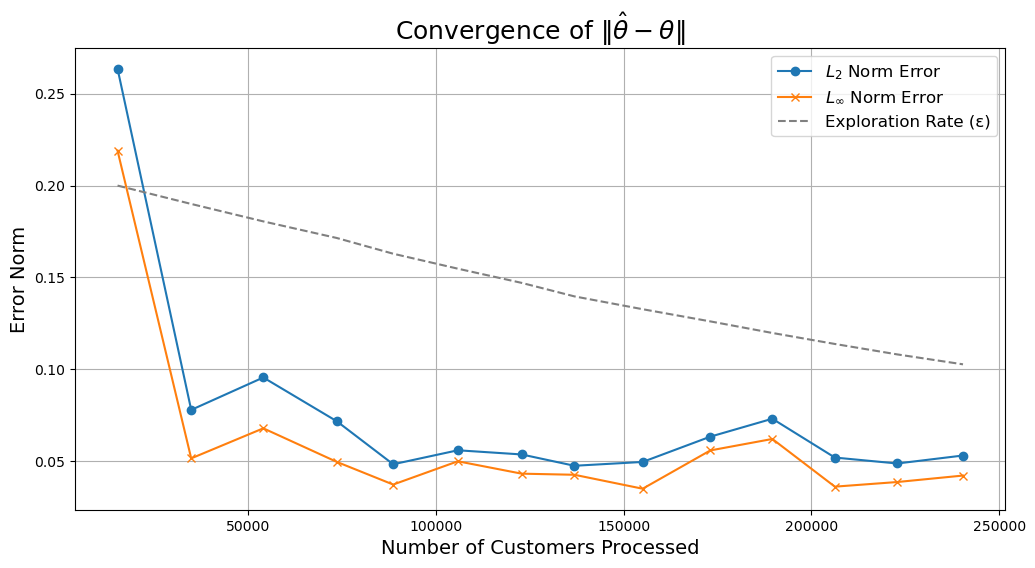

In [7]:
# simulator = Simulator.load('models/simulator_0914')

history = pd.DataFrame(simulator.history)
degradation_history = pd.DataFrame(simulator.degradation_history)

epsilons = [0.20 * (0.95 ** i) for i in range(len(simulator.theta_updates))]

times = []

for d in simulator.theta_updates:
    idx, theta_hat = d['customer_idx'], d['theta_hat']
    time = history[history.customer_id == idx]['calendar_time'].max()
    times.append(time)
    
# plot L2, and L-inf norms of utility updates
L2_errors = [np.linalg.norm(update['theta_hat'] - THETA_TRUE) for update in simulator.theta_updates]
Linf_errors = [np.linalg.norm(update['theta_hat'] - THETA_TRUE, ord=np.inf) for update in simulator.theta_updates]

plt.figure(figsize=(12, 6))
plt.plot(times, L2_errors, label='$L_2$ Norm Error', marker='o')
plt.plot(times, Linf_errors, label='$L_\infty$ Norm Error', marker='x')
plt.plot(times, epsilons, label='Exploration Rate (ε)', linestyle='--', color='gray')
# plt.yscale('log')
plt.xlabel('Number of Customers Processed', fontsize=14)
plt.ylabel('Error Norm', fontsize=14)

plt.title('Convergence of $\|\hat{\\theta} - \\theta\|$', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('figures/utility_convergence.pdf')
plt.show()

### Convergence of $\hat u$

In [ ]:
simulator.utility_updates

# plot L2, and L-inf norms of utility updates
L2_errors = [np.linalg.norm(update['u_hat'] - UTILITY_TRUE) for update in simulator.utility_updates]
Linf_errors = [np.linalg.norm(update['u_hat'] - UTILITY_TRUE, ord=np.inf) for update in simulator.utility_updates]

plt.figure(figsize=(12, 6))
plt.plot(L2_errors, label='$L_2$ Norm Error', marker='o')
plt.plot(Linf_errors, label='$L_\infty$ Norm Error', marker='x')
# plt.yscale('log')
plt.xlabel('Number of Customers Processed', fontsize=14)
plt.ylabel('Error Norm', fontsize=14)

plt.title('Convergence of $\|\hat u - u\|$', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('figures/utility_convergence.pdf')
plt.show()

### Revenue of Online Learner

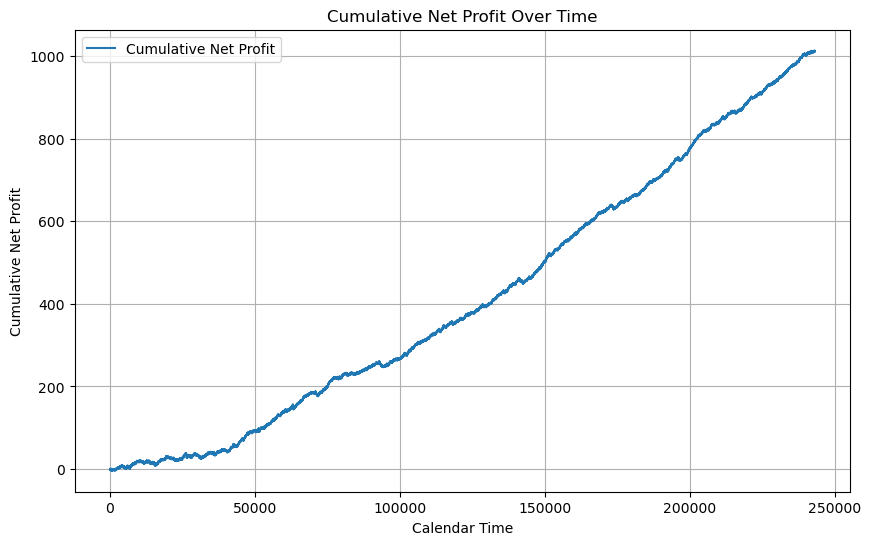

In [8]:
degradation_df = pd.DataFrame(simulator.degradation_history)
simulation_df = pd.DataFrame(simulator.history)

simulation_df['net_profit'] = simulation_df['profit'] + simulation_df['loss']
simulation_df['cumulative_net_profit'] = simulation_df['net_profit'].cumsum()

ax = plt.figure(figsize=(10,6))

# plot cumulative profit and loss over time
plt.plot(simulation_df['calendar_time'], simulation_df['cumulative_net_profit'], label='Cumulative Net Profit')
plt.xlabel('Calendar Time')
plt.ylabel('Cumulative Net Profit')
plt.title('Cumulative Net Profit Over Time')
plt.legend()
plt.grid()
plt.savefig('figures/cumulative_net_profit_online.pdf')
plt.show()

## Training policy under perfect information

### Revenue of Optimal Policy

In [9]:
class PerfectDegradationLearner:
    def __init__(self, d, theta_true, hazard_model):
        self.d = d
        self.theta_true = theta_true
        self.hazard_model = hazard_model  # Placeholder, not used
        
    def get_theta(self):
        return self.theta_true
    
    def cum_baseline(self, t):
        return self.hazard_model.Lambda_0(t)
    
    def inverse_cum_baseline(self, u):
        return self.hazard_model.Lambda_0_inverse(u)
    
perfect_degradation_learner = PerfectDegradationLearner(
    d=D, 
    theta_true=THETA_TRUE,
    hazard_model=usage_exp_hazard_model,
)

# N_perfect = [100, 40, 80, 150]

perfect_dpagent = DiscretizedDPAgent(
    N=simulator.training_hyperparams['N'], # grid sizes [cum_context, context, duration, active_time]
    max_cumulative_context=simulator.training_hyperparams['max_cumulative_context'],
    # max_active_time=simulator.training_hyperparams['max_active_time'],
    u_hat=UTILITY_TRUE,
    degradation_learner=perfect_degradation_learner,
    customer_generator=customer_gen,
    params=simulator.mdp_params,
)
# perfect_dpagent.run_value_iteration(simulator.training_hyperparams['num_value_iterations'])

# weight = torch.load('weights/perfect_dpagent_q_network.pth', map_location=torch.device('cuda'))
# perfect_dpagent.q_network.load_state_dict(weight)
# perfect_dpagent.q_network.to(perfect_dpagent.device)
# perfect_dpagent.q_network.eval()
perfect_dpagent._precompute_dynamics(100000)
perfect_dpagent.run_value_iteration(150)
perfect_policy = perfect_dpagent.get_policy('greedy')

Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...
Pre-computation complete. ✅
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...
Pre-computation complete. ✅

Starting Value Iteration...
Iteration 10/150 | Max Change (Delta): 0.209637
Iteration 20/150 | Max Change (Delta): 0.154076
Iteration 30/150 | Max Change (Delta): 0.122849
Iteration 40/150 | Max Change (Delta): 0.099745
Iteration 50/150 | Max Change (Delta): 0.081427
Iteration 60/150 | Max Change (Delta): 0.066566
Iteration 70/150 | Max Change (Delta): 0.054437
Iteration 80/150 | Max Change (Delta): 0.044523
Iterat

In [11]:
simulation_df = pd.DataFrame(simulator.history)
# simulator.degradation_learner = perfect_degradation_learner
samples = simulator.run_full_exploit(100000, perfect_policy, {'tau': 0.01})
samples = pd.DataFrame(samples)

simulation_df['net_profit'] = simulation_df['profit'] + simulation_df['loss']
simulation_df['cumulative_net_profit'] = simulation_df['net_profit'].cumsum()
samples['net_profit'] = samples['profit'] + samples['loss']
samples['cumulative_net_profit'] = samples['net_profit'].cumsum()

samples['netprofit_per_time'] = samples['cumulative_net_profit'] / samples['calendar_time']
simulation_df['netprofit_per_time'] = simulation_df['cumulative_net_profit'] / simulation_df['calendar_time']

INFO:root:Starting simulation for 100000 customers...
100%|██████████| 100000/100000 [00:02<00:00, 33407.04it/s]
INFO:root:Simulation finished.


In [19]:
def calculate_rolling_rate(df, time_col, value_col, window_size):
    """
    Calculates the rate of a value over a rolling time window on irregular time series data.

    Args:
        df (pd.DataFrame): The input dataframe.
        time_col (str): The name of the column with time data.
        value_col (str): The name of the column with values to aggregate (e.g., 'net_profit').
        window_size (int): The duration of the rolling time window.

    Returns:
        pd.Series: A series containing the calculated rolling rate for each row.
    """
    # Ensure the dataframe is sorted by time, which is crucial.
    df = df.sort_values(time_col).reset_index(drop=True)
    
    times = df[time_col].values
    values = df[value_col].values
    
    # For each end time `t_i`, find the start time `t_i - window`.
    start_times = times - window_size
    
    # Use searchsorted to find the index where each start_time would be inserted.
    # This gives us the starting index of each time window efficiently.
    start_indices = np.searchsorted(times, start_times, side='left')
    
    # Use a cumulative sum to efficiently calculate the sum over any slice [j, i].
    value_cumsum = np.cumsum(values)
    
    # The sum for a window ending at `i` is cumsum[i] - cumsum[start_index - 1].
    # We create a shifted cumulative sum array to handle the `start_index - 1` lookup.
    shifted_cumsum = np.concatenate(([0], value_cumsum[:-1]))
    
    # Calculate the sum of values within each rolling window.
    window_sums = value_cumsum - shifted_cumsum[start_indices]
    
    # The rate is the sum of profit in the window divided by the window's duration.
    profit_rate = window_sums / window_size
    
    return pd.Series(profit_rate, index=df.index)


# --- 2. Calculate net profit and the rolling rate for each DataFrame ---

window_duration = 20000 # Define the time window for the rolling rate

for df in [simulation_df, samples]:
# for df in [samples]:
    df['net_profit'] = df['profit'] + df['loss']
    # Add the new 'profit_rate' column using our helper function
    df['profit_rate'] = calculate_rolling_rate(df, 'calendar_time', 'net_profit', window_duration)

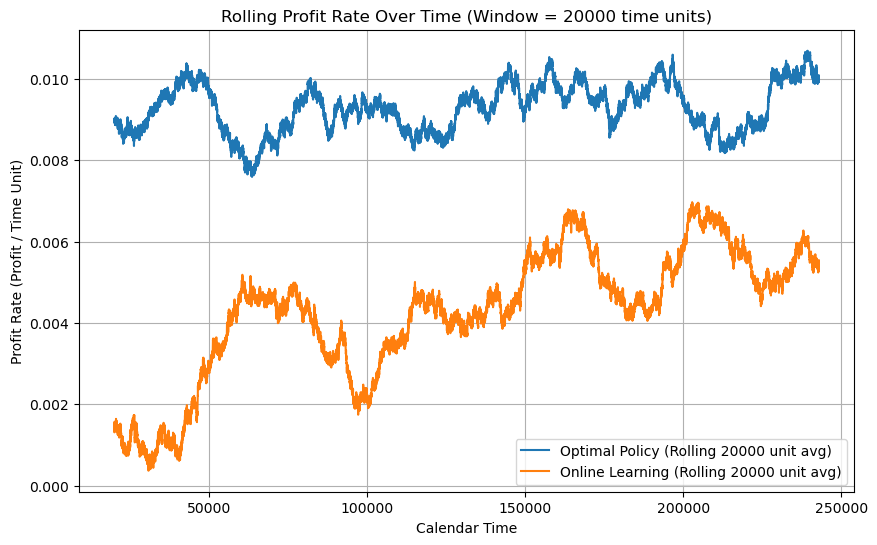

In [20]:
# --- 3. Plot the new rolling profit rate ---

max_time = min(simulation_df['calendar_time'].max(), samples['calendar_time'].max())
samples_plot = samples[(window_duration <= samples['calendar_time']) & (samples['calendar_time'] <= max_time)]
simulations_plot = simulation_df[
    (window_duration <= simulation_df['calendar_time']) &
    (simulation_df['calendar_time'] <= max_time)]


plt.figure(figsize=(10, 6))

plt.plot(samples_plot['calendar_time'], samples_plot['profit_rate'], label=f'Optimal Policy (Rolling {window_duration} unit avg)')
plt.plot(simulations_plot['calendar_time'], simulations_plot['profit_rate'], label=f'Online Learning (Rolling {window_duration} unit avg)')

plt.xlabel('Calendar Time')
plt.ylabel('Profit Rate (Profit / Time Unit)')
plt.title(f'Rolling Profit Rate Over Time (Window = {window_duration} time units)')
plt.legend()
plt.grid(True)
plt.show()